In [6]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, LSTM, Dropout, add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


### 1. Paths

In [ ]:
train_img_path = "../coco/train2014"
val_img_path   = "../coco/val2014"
ann_path       = "../coco/annotations"
train_ann_file = f"{ann_path}/captions_train2014.json"
val_ann_file   = f"{ann_path}/captions_val2014.json"


### 2. Load and clean captions

In [8]:
def load_coco_annotations(ann_file):
    with open(ann_file, "r") as f:
        captions = json.load(f)
    id_to_filename = {img["id"]: img["file_name"] for img in captions["images"]}
    rows = []
    for ann in captions["annotations"]:
        rows.append([id_to_filename[ann["image_id"]], ann["caption"]])
    return pd.DataFrame(rows, columns=["image", "caption"])

import re
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z]', ' ', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    caption = " ".join([w for w in caption.split() if len(w) > 1])
    return f"startseq {caption} endseq"

def text_preprocessing(df):
    df['caption'] = df['caption'].apply(clean_caption)
    return df

train = load_coco_annotations(train_ann_file)
val   = load_coco_annotations(val_ann_file)

train = text_preprocessing(train)
val   = text_preprocessing(val)


### 3. Tokenizer

In [12]:
captions = train['caption'].tolist()

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [13]:
print("Maximum caption length:", max_length)
print("Vocab Size:", vocab_size)


Maximum caption length: 49
Vocab Size: 22806


In [9]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

### 4. Feature extraction

In [ ]:
# custom cnn
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

base_model = Model(inputs, x)
fe = base_model

def extract_features(df, img_dir, save_path, img_size=224):
    features = {}
    for image in tqdm(df['image'].unique()):
        img = load_img(os.path.join(img_dir, image), target_size=(img_size, img_size))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        features[image] = fe.predict(img, verbose=0)
    with open(save_path, "wb") as f:
        pickle.dump(features, f)
    return features

train_features = extract_features(train, train_img_path, "train_features.pkl")
val_features   = extract_features(val, val_img_path, "val_features.pkl")

fe.save("feature_extractor.keras")


  0%|          | 0/82783 [00:00<?, ?it/s]2025-09-11 06:14:07.187886: I external/local_xla/xla/service/service.cc:163] XLA service 0x7715180d3480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-11 06:14:07.187924: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-09-11 06:14:07.583586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-11 06:14:09.839496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
I0000 00:00:1757571278.704954    1933 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 40504/40504 [1:47:11<00:00,  6.30it/s]   


In [10]:
import pickle

# Load train features
with open("train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

# Load validation features
with open("val_features.pkl", "rb") as f:
    val_features = pickle.load(f)

print(f"Number of train images features: {len(train_features)}")
print(f"Number of validation images features: {len(val_features)}")


Number of train images features: 82783
Number of validation images features: 40504


### 5.Data Generator

In [14]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory,
                 tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

train_generator = CustomDataGenerator(train, 'image', 'caption', 64,
                                      train_img_path, tokenizer, vocab_size,
                                      max_length, train_features)

val_generator = CustomDataGenerator(val, 'image', 'caption', 64,
                                    val_img_path, tokenizer, vocab_size,
                                    max_length, val_features)


### 6.Model

In [15]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### 7.Training

In [ ]:
checkpoint = ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, mode="min")
earlystopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, verbose=1)

history = caption_model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr]
)


Epoch 1/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1850s 285ms/step - accuracy: 0.2833 - loss: 4.1105 - val_accuracy: 0.3495 - val_loss: 3.4366 - learning_rate: 0.0010
Epoch 2/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1816s 281ms/step - accuracy: 0.3275 - loss: 3.6489 - val_accuracy: 0.3631 - val_loss: 3.3036 - learning_rate: 0.0010
Epoch 3/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1821s 281ms/step - accuracy: 0.3382 - loss: 3.5424 - val_accuracy: 0.3701 - val_loss: 3.2467 - learning_rate: 0.0010
Epoch 4/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 2802s 433ms/step - accuracy: 0.3443 - loss: 3.4846 - val_accuracy: 0.3732 - val_loss: 3.2192 - learning_rate: 0.0010
Epoch 5/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 4447s 687ms/step - accuracy: 0.3483 - loss: 3.4481 - val_accuracy: 0.3754 - val_loss: 3.2031 - learning_rate: 0.0010
Epoch 6/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1856s 287ms/step - accuracy: 0.3510 - loss: 3.4225 - val_accuracy: 0.3783 - val_loss: 3.1894 - learning_rate: 0.0010
Epoch 7/35
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1882

In [17]:
from tensorflow.keras.models import load_model

model = load_model("model.keras")

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Redefine the callbacks
checkpoint = ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, mode="min")
earlystopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, verbose=1)



In [18]:
history = model.fit(
    train_generator,
    epochs=20,                  # final target
    initial_epoch=16,           # since finished 16 already
    validation_data=val_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr]
)

/mnt/d/Bhumika/Image caption generator/kaggle/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 17/20


2025-09-12 12:33:17.214770: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


6470/6470 ━━━━━━━━━━━━━━━━━━━━ 4203s 649ms/step - accuracy: 0.3748 - loss: 3.2192 - val_accuracy: 0.3893 - val_loss: 3.1272 - learning_rate: 2.0000e-04
Epoch 18/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1918s 296ms/step - accuracy: 0.3763 - loss: 3.2095 - val_accuracy: 0.3905 - val_loss: 3.1240 - learning_rate: 2.0000e-04
Epoch 19/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1899s 293ms/step - accuracy: 0.3772 - loss: 3.2008 - val_accuracy: 0.3904 - val_loss: 3.1239 - learning_rate: 2.0000e-04
Epoch 20/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 1912s 295ms/step - accuracy: 0.3778 - loss: 3.1957 - val_accuracy: 0.3907 - val_loss: 3.1208 - learning_rate: 2.0000e-04


# Plotting

In [19]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


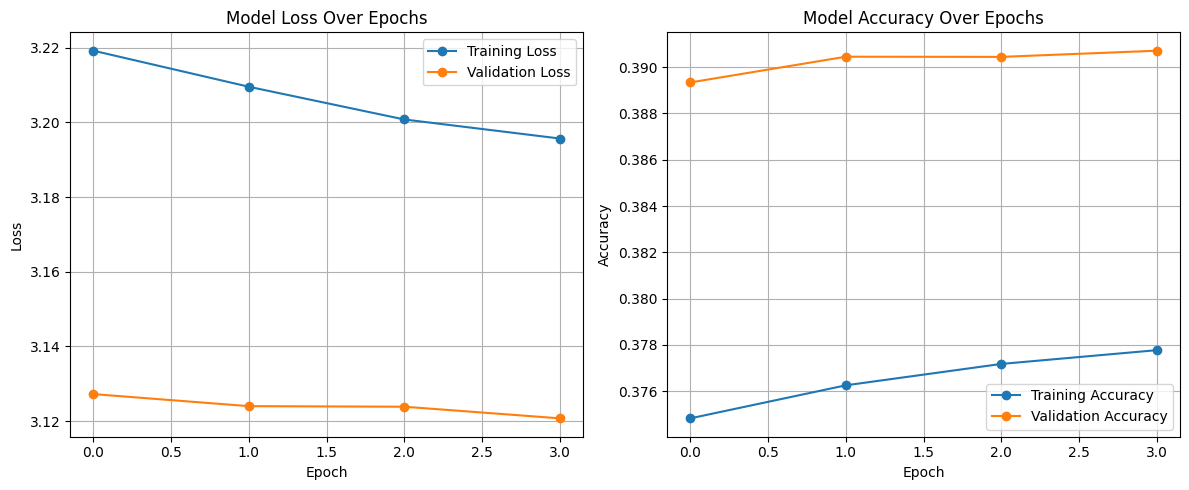

In [20]:
import matplotlib.pyplot as plt

# Check what keys are available (loss, accuracy, val_loss, val_accuracy, etc.)
# print(history.history.keys())

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy if available
if 'accuracy' in history.history:
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### 8. Caption generation & BLEU evaluation

In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap


In [21]:
import os
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

# Import COCO evaluation scorers
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice


def generate_caption(image_path, model, tokenizer, feature_extractor, max_length=49, img_size=224):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)

    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    return in_text.replace("startseq", "").replace("endseq", "").strip()



In [26]:

caption_model = load_model("model.keras")
fe = load_model("feature_extractor.keras")
# Collect refs and hyps
gts, res = {}, {}

for i, img_name in enumerate(tqdm(val['image'].unique()[:800])):  # limit for speed
    img_path_full = os.path.join(val_img_path, img_name)

    # ground-truth references
    ref_caps = val[val['image'] == img_name]['caption'].tolist()
    ref_caps_clean = [r.replace("startseq", "").replace("endseq", "").strip() for r in ref_caps]

    # prediction
    pred_caption = generate_caption(img_path_full, caption_model, tokenizer, fe, max_length)

    # save in COCO format
    gts[i] = ref_caps_clean
    res[i] = [pred_caption]


# Evaluate using COCO metrics
scorers = [
    (Bleu(4), "BLEU"),
    (Rouge(), "ROUGE_L"),
    (Cider(), "CIDEr"),  
]

for scorer, name in scorers:
    score, scores = scorer.compute_score(gts, res)
    if isinstance(score, list):  # BLEU returns list for 1–4
        for i, s in enumerate(score):
            print(f"{name}-{i+1}: {s:.4f}")
    else:
        print(f"{name}: {score:.4f}")


100%|██████████| 800/800 [09:46<00:00,  1.36it/s]


{'testlen': 6116, 'reflen': 6313, 'guess': [6116, 5316, 4516, 3716], 'correct': [3461, 1231, 349, 86]}
ratio: 0.9687945509265058
BLEU-1: 0.5480
BLEU-2: 0.3505
BLEU-3: 0.2095
BLEU-4: 0.1198
ROUGE_L: 0.3921
CIDEr: 0.4608


In [ ]:
# from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from tqdm import tqdm
# import os

# smooth = SmoothingFunction().method1

# def generate_caption(image_path, model, tokenizer, feature_extractor, max_length=max_length, img_size=224):
#     img = load_img(image_path, target_size=(img_size, img_size))
#     img = img_to_array(img) / 255.0
#     img = np.expand_dims(img, axis=0)
#     image_features = feature_extractor.predict(img, verbose=0)

#     in_text = "startseq"
#     for _ in range(max_length):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], maxlen=max_length)
#         yhat = model.predict([image_features, sequence], verbose=0)
#         yhat_index = np.argmax(yhat)
#         word = tokenizer.index_word.get(yhat_index, None)
#         if word is None:
#             break
#         in_text += " " + word
#         if word == "endseq":
#             break
#     return in_text.replace("startseq", "").replace("endseq", "").strip()


# # Collect refs and hyps
# references, hypotheses = [], []
# for img_name in tqdm(val['image'].unique()[:8000]):  # limit to 1k for speed
#     img_path_full = os.path.join(val_img_path, img_name)

#     # ground-truth references
#     ref_caps = val[val['image']==img_name]['caption'].tolist()
#     ref_caps = [r.replace("startseq","").replace("endseq","").split() for r in ref_caps]

#     # model prediction
#     pred_caption = generate_caption(img_path_full, caption_model, tokenizer, fe, max_length)
#     pred_tokens = pred_caption.split()

#     references.append(ref_caps)
#     hypotheses.append(pred_tokens)

# # Compute BLEU scores
# print("Corpus BLEU-1:", corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smooth))
# print("Corpus BLEU-2:", corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))
# print("Corpus BLEU-3:", corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth))
# print("Corpus BLEU-4:", corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))


# Visualization function

In [27]:
import random
from textwrap import wrap
def show_grid(val_df, val_img_path, model, tokenizer, feature_extractor, 
              max_length=max_length, img_size=224, n=9):
    # pick n random images from validation set
    img_names = random.sample(val_df['image'].unique().tolist(), n)

    plt.figure(figsize=(20, 20))
    for idx, img_name in enumerate(img_names, 1):
        img_path_full = os.path.join(val_img_path, img_name)

        # reference captions (pick 1 random for display)
        ref_caps = val_df[val_df['image']==img_name]['caption'].tolist()
        ref_caps = [r.replace("startseq","").replace("endseq","").strip() for r in ref_caps]
        ref_cap = random.choice(ref_caps)

        # predicted caption
        pred_caption = generate_caption(img_path_full, model, tokenizer, feature_extractor, max_length)

        # plot
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), idx)
        image = load_img(img_path_full, target_size=(img_size, img_size))
        plt.imshow(image)
        plt.axis("off")

        # wrap captions for readability
        pred_wrapped = "\n".join(wrap("Pred: " + pred_caption, 30))
        ref_wrapped = "\n".join(wrap("Ref: " + ref_cap, 30))

        plt.title(pred_wrapped + "\n" + ref_wrapped, fontsize=10, color="black")

    plt.tight_layout()
    plt.show()


# usage

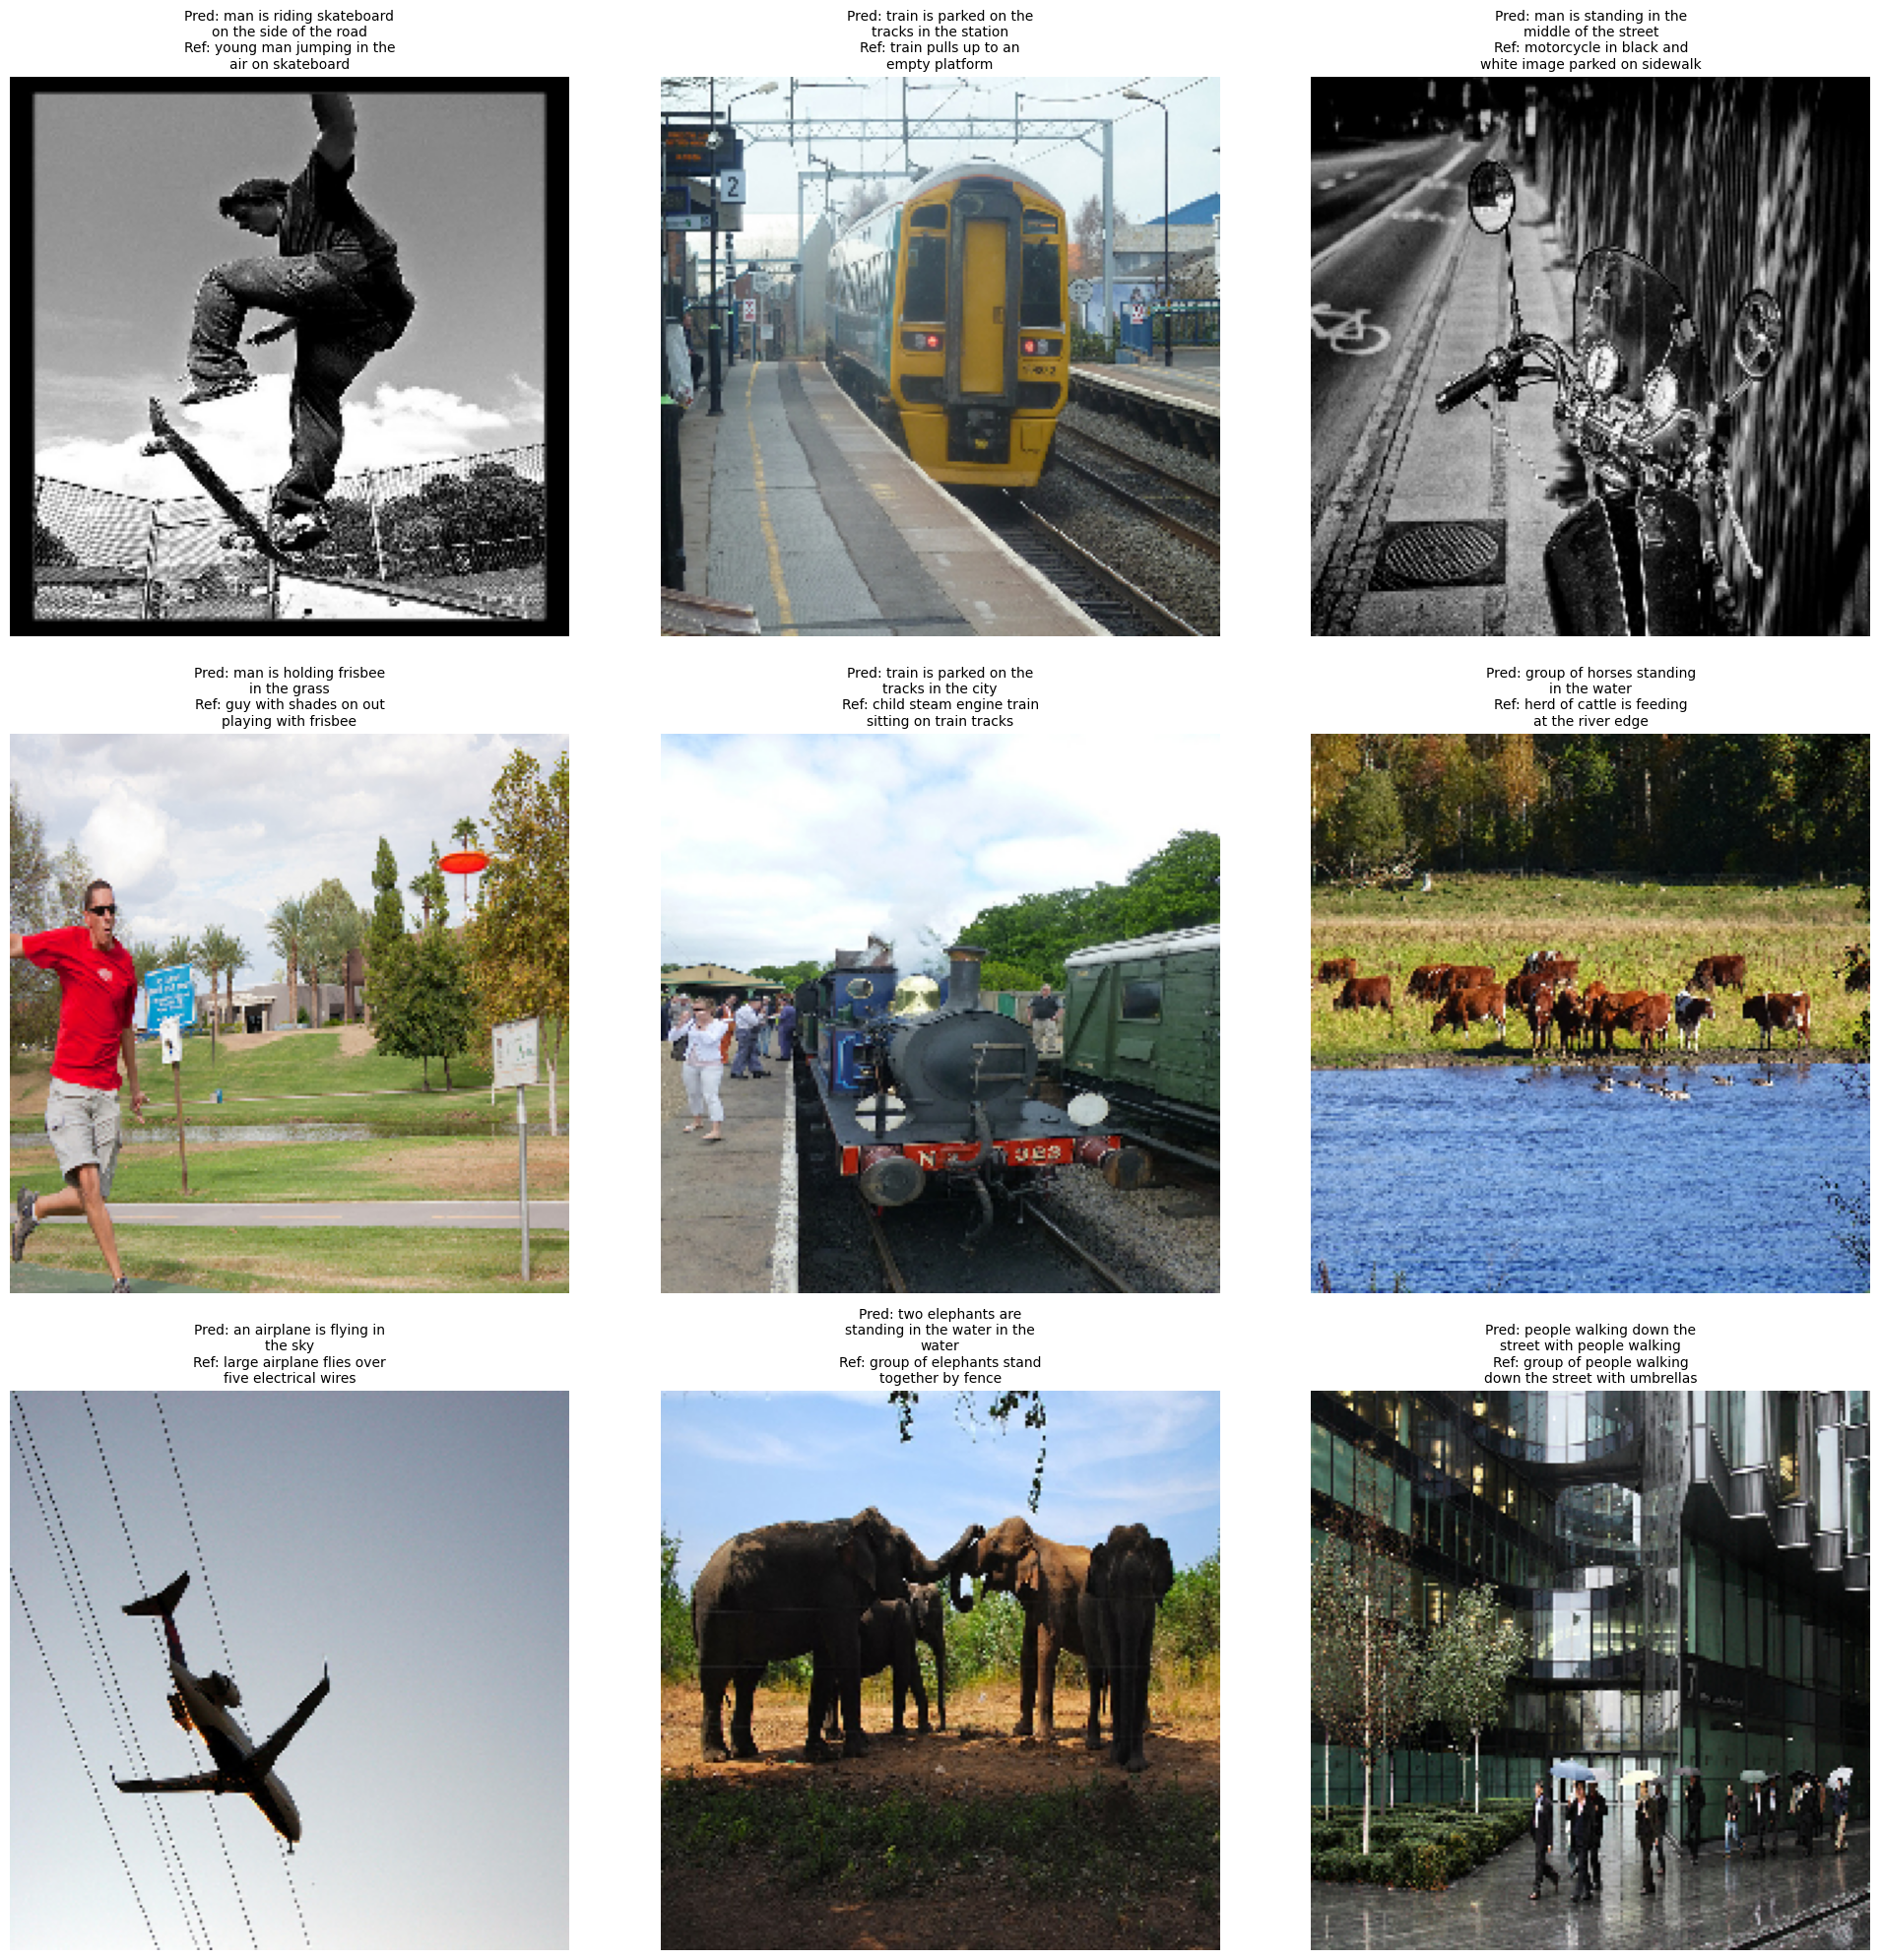

In [28]:
# Show 9 validation images with captions
show_grid(val, val_img_path, caption_model, tokenizer, fe, max_length, n=9)
